In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset/brain-tumor-class.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Found 2870 images belonging to 4 classes.


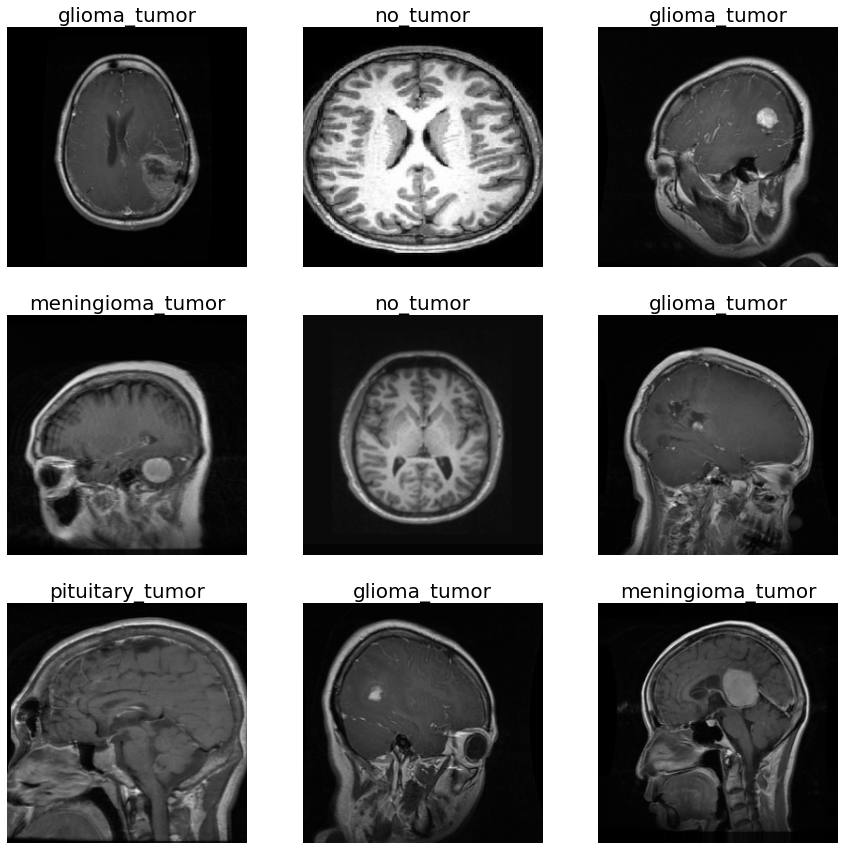

In [5]:
#checking train labels and images randomly
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

import matplotlib.pyplot as plt

train_set_check = train_datagen.flow_from_directory('/content/brain-tumor-class/Training',
                                             target_size=(256,256),
                                             batch_size=16,
                                             class_mode='sparse', shuffle=True)

class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
plt.figure(figsize=(15, 15))

batch=next(train_set_check)  

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img=batch[0][i]                            
    plt.imshow(img)
    lab = int(batch[1][i])
    plt.title(class_names[lab], fontsize=20)
    plt.axis("off")

In [6]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-class','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-class','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 146.84it/s]


In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
from tensorflow.keras.models import Sequential

model_cnn = Sequential()
model_cnn.add(Input(shape=(150,150,3)))
model_cnn.add(Conv2D(128,(3,3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(128,(3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(128,(3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(128,(3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(128,(3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(128,(2,2), activation='relu'))
model_cnn.add(MaxPooling2D((1,1)))

model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64,activation='relu'))
model_cnn.add(Dense(4,activation='softmax'))

In [11]:
model_cnn.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [13]:
history = model_cnn.fit(X_train,y_train,validation_split=0.2, epochs=20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.4488
Epoch 00001: val_accuracy improved from -inf to 0.30210, saving model to effnet.h5
66/66 [==============================] - 21s 237ms/step - loss: 1.1949 - accuracy: 0.4488 - val_loss: 1.7196 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.9233 - accuracy: 0.5862
Epoch 00002: val_accuracy improved from 0.30210 to 0.55449, saving model to effnet.h5
66/66 [==============================] - 13s 196ms/step - loss: 0.9233 - accuracy: 0.5862 - val_loss: 1.0305 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6743
Epoch 00003: val_accuracy improved from 0.55449 to 0.68069, saving model to effnet.h5
66/66 [==============================] - 12s 189ms/step - loss: 0.7389 - accuracy: 0.6743 - val_loss: 0.7999 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 4/20
66/66 [==========

<Figure size 432x288 with 0 Axes>

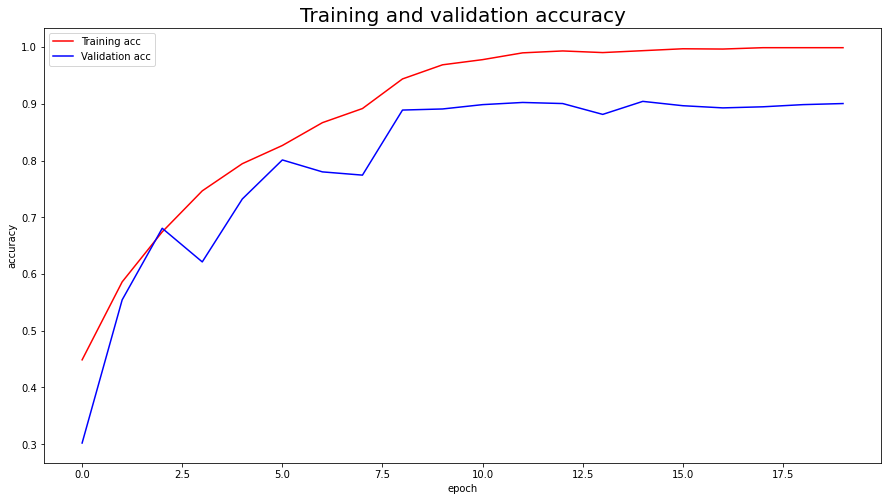

<Figure size 432x288 with 0 Axes>

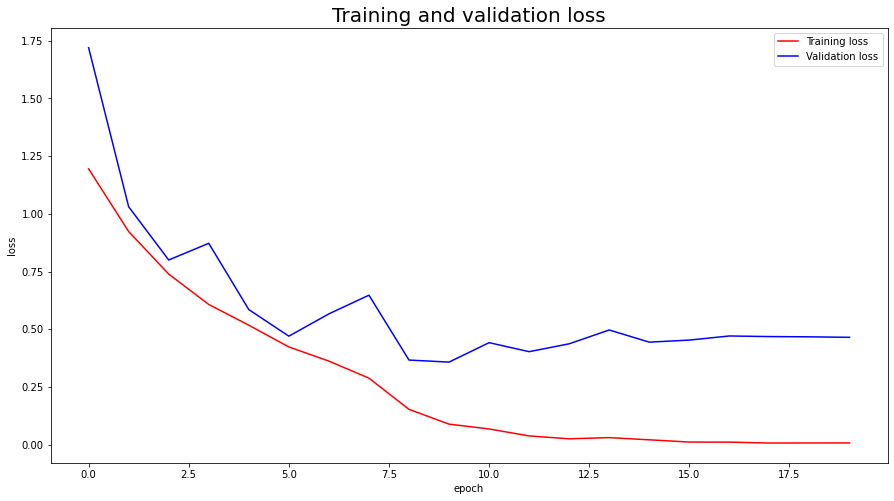

<Figure size 432x288 with 0 Axes>

In [14]:
#Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()


plt.figure(figsize=(15, 8))

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

In [15]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85       168
           1       0.94      0.86      0.90       108
           2       0.85      0.90      0.87       201
           3       0.92      0.99      0.95       176

    accuracy                           0.89       653
   macro avg       0.90      0.89      0.89       653
weighted avg       0.90      0.89      0.89       653



<Figure size 432x288 with 0 Axes>

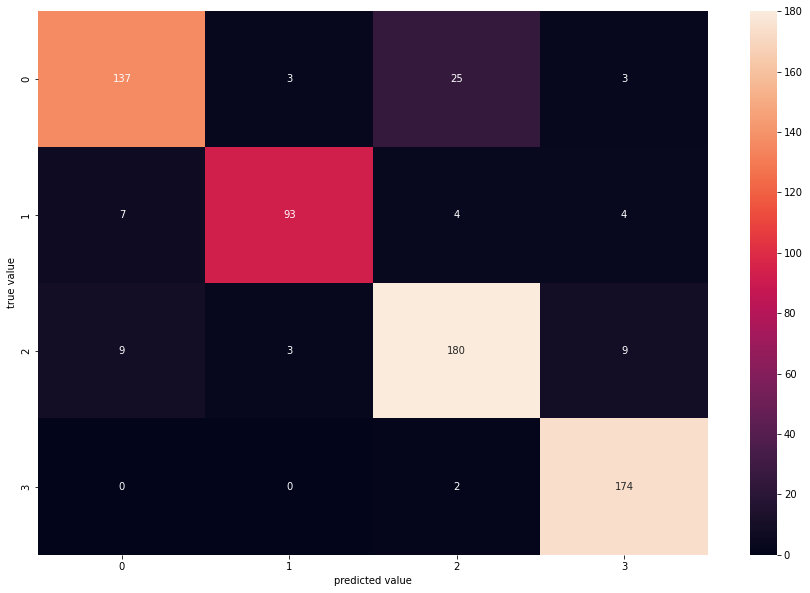

<Figure size 432x288 with 0 Axes>

In [17]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

conf_matrix = confusion_matrix(y_test_new,pred)
sns.heatmap(conf_matrix,annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

plt.figure()

In [18]:
# Training Accuracy
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
y_train_new = np.argmax(y_train, axis=1)

count_train = 0
for i in range(0, len(train_pred)):
  if train_pred[i] == y_train_new[i]:
    count_train += 1

x1 = count_train/len(train_pred)

# Validation Accuracy
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

count_test = 0
for i in range(0, len(test_pred)):
  if test_pred[i] == y_test_new[i]:
    count_test += 1

x2 = count_test/len(test_pred)

print('Training Accuracy  : %1.2f%%'%(x1*100))
print('Validation Accuracy: %1.2f%%'%(x2*100))

Training Accuracy  : 97.97%
Validation Accuracy: 89.43%
